In [ ]:
# Install specialized NLDR & Wasserstein packages (if not installed already)
!yes | pip install -U --quiet https://github.com/PythonOT/POT/archive/master.zip 
!yes | pip install -U --quiet pyDiffMap
# Update matplotlib to use subplot_mosaic. 
!yes | pip install -U --quiet matplotlib==3.5

In [1]:
import sys
sys.path.append("../../") # Add base code dir to import wassmap (note: not necessary if wassmap was installed using pip)

import wassmap as wm
import numpy as np
import networkx as nx
import time
import sklearn
import math
from sklearn import manifold as man
from sklearn.decomposition import PCA
from pydiffmap import diffusion_map as dm

import matplotlib.pyplot as plt

from torch import HalfStorage

In [2]:
# Some global figure settings
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
        'axes.titlesize': 32
         }

plt.rcParams.update(params)
 
font = {'family':'serif','weight':'normal','size':18}
plt.rc('font',**font)

# Colormap stuff 
plt.rc('image', cmap='gnuplot')
# Colormap function 
colorfun = lambda x,y: x+math.pi*y/2.0

np.set_printoptions(edgeitems=30, linewidth=100000,formatter=dict(float=lambda x: "%.3g" % x))

In [61]:
### FIGURE 1: Circle translate test 1:OVERLAPPING IMAGES::Computations
# NOTE: In this test, the translation grid is such that the resulting synthetic 
# images will overlap.  Thus, Isomap is at least well-defined (i.e. there are meaningful geodesics)

# Generate base circle
num_samplepoints = 64
circ = wm.generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set
num_translates = 5
num_samp_f1 = num_translates**2
x = np.linspace(-1,1,num=num_translates)
xx,yy = np.meshgrid(x,x) 
xx = np.reshape(xx,(num_samp_f1,1))
yy = np.reshape(yy,(num_samp_f1,1))
translates_f1 = np.zeros((num_samp_f1,2))
for i in range(len(xx)):
    translates_f1[i,0] = xx[i]
    translates_f1[i,1] = yy[i]
    
# Generate translation images and image tensor
trans_images_f1 = []
for i in range(num_samp_f1):
    img = np.concatenate((wm.translation(circ,[translates_f1[i,0],translates_f1[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    trans_images_f1.append(img)

# Generate voxel images (for ISOmap)
nvox = 256
xg = np.linspace(-2,2,nvox)
xxg,yyg = np.meshgrid(xg,xg,indexing='ij')
grid = np.stack((xxg,yyg))
# Format required for our voxel-based methods
trans_images_vox_f1 = np.zeros((nvox,nvox,num_translates**2))
# Format required for scikitlearn
vox_matrix_f1 = np.zeros((num_translates**2,nvox*nvox))
for i in range(num_samp_f1):
    pc = trans_images_f1[i]
    trans_images_vox_f1[:,:,i] = wm.pointcloud_to_vox(pc,grid)
    vox_matrix_f1[i,:] = np.reshape(trans_images_vox_f1[:,:,i],(1,nvox*nvox))

In [ ]:
# Compute Wasserstein square distance matrix
tic = time.perf_counter()
wass_p = 2.0
Wass_distance_f1 = wm.wass_matrix(trans_images_f1,squared=True,geodesic=False,p=wass_p)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp_f1,toc))

# MDS on Wass squared matrix to obtain the Wassmap embedding
WassEmbedding_f1 = wm.mds(Wass_distance_f1,squared=True)

In [4]:
# Figure 1: Compute the Euclidean MDS, Isomap and Diffusion map embeddings 
# Compute Euclidean MDS embedding (not Isomap, plain MDS)
euc_matrix_f1 = wm.euc_matrix(trans_images_vox_f1,geodesic=False,squared=True,plot=False)
MDSEmbedding_f1 = wm.mds(euc_matrix_f1,squared=True)

# Compute ISOMAP embedding using sklearn 
isomap_k = 5
IsomapEmbedding_f1 = man.Isomap(n_components=2,n_neighbors=isomap_k).fit_transform(vox_matrix_f1)

# Compute the diffusion map using PyDiffMap
neighbor_params = {'n_jobs': -1, 'algorithm': 'kd_tree'} 
dmap_f1 = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 1, neighbor_params = neighbor_params,k = 64)
DMapEmbedding_f1 = dmap_f1.fit_transform(vox_matrix_f1)
print('Fitted epsilon = %1.4e'%dmap_f1.epsilon_fitted)

Fitted epsilon = 1.2207e-04


/var/folders/yq/ycx24n5j4ysbzlhns70dbm400000gn/T/ipykernel_40746/3647924577.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1['C'].set_xticklabels(ax1['C'].get_xticks(), rotation = 45)
/var/folders/yq/ycx24n5j4ysbzlhns70dbm400000gn/T/ipykernel_40746/3647924577.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1['E'].set_xticklabels(ax1['E'].get_xticks(), rotation = 45)


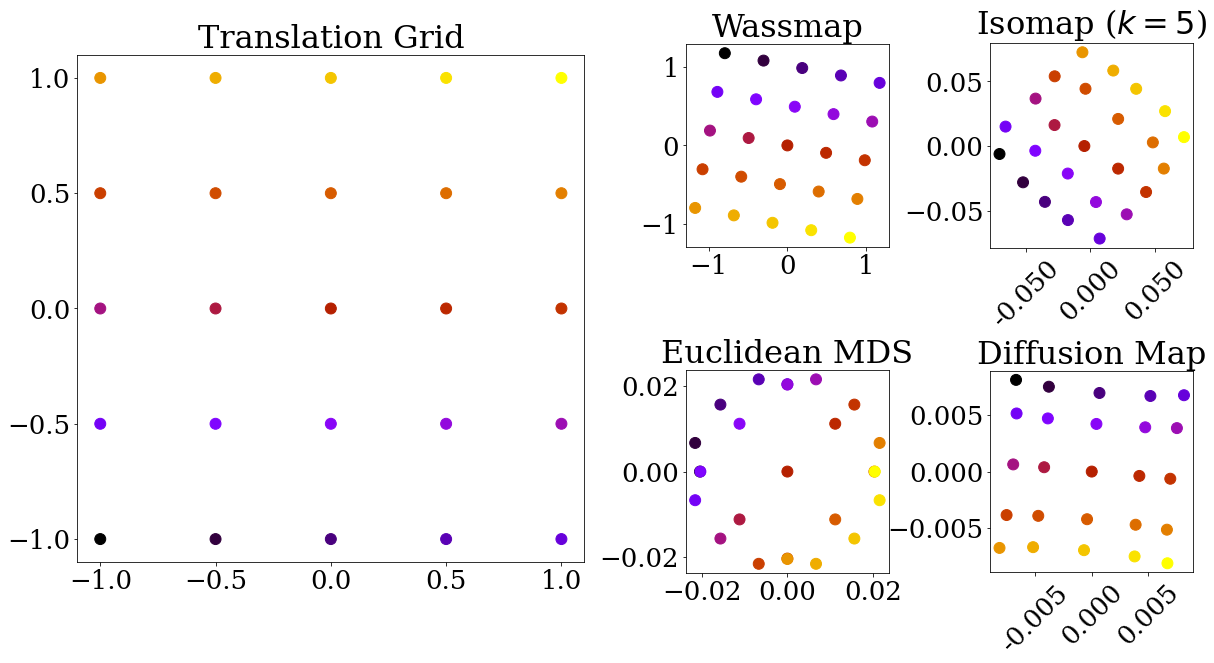

In [67]:
### FIGURE 1: Circle translate test 1:OVERLAPPING IMAGES:Plotting

# Create the plot objects 
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.subplot_mosaic(
    """
    AABC
    AADE
    """,
    gridspec_kw = {"wspace":0.5,"hspace":0.5},
    empty_sentinel="X",
)

ms = 120 # Marker size 
xp = translates_f1[:,0]
yp = translates_f1[:,1]
c = np.linspace(0,1,num_samp_f1)   # Note: we'll use the same colors for every scatter plot (to identify points)

# Plot the translation set 
ax1['A'].scatter(xp,yp,c=c,s=ms)
ax1['A'].set_aspect('equal')
ax1['A'].set_title('Translation Grid')
ax1['A'].set_xticks(x)
ax1['A'].set_yticks(x)

# Plot the Wassmap embedding
xp = WassEmbedding_f1[:,0]
yp = WassEmbedding_f1[:,1]
ax1['B'].scatter(xp,yp,c=c,s=ms)
ax1['B'].set_aspect('equal')
ax1['B'].set_title('Wassmap')

# Plot the ISOMAP embedding
xp = IsomapEmbedding_f1[:,0]
yp = IsomapEmbedding_f1[:,1]
ax1['C'].scatter(xp,yp,c=c,s=ms)
ax1['C'].set_aspect('equal')
ax1['C'].set_title("Isomap ($k=%i$)"%isomap_k)
ax1['C'].set_xticklabels(ax1['C'].get_xticks(), rotation = 45)
ax1['C'].get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.3f'))

# Plot the Euclidean MDS embedding
xp = MDSEmbedding_f1[:,0]
yp = MDSEmbedding_f1[:,1]
ax1['D'].scatter(xp,yp,c=c,s=ms)
ax1['D'].set_aspect('equal')
ax1['D'].set_title('Euclidean MDS')

# Plot the diffusion map embedding 
xp = DMapEmbedding_f1[:,0]
yp = DMapEmbedding_f1[:,1]
ax1['E'].scatter(xp,yp,c=c,s=ms)
ax1['E'].set_aspect('equal')
ax1['E'].set_title('Diffusion Map')
ax1['E'].set_xticklabels(ax1['E'].get_xticks(), rotation = 45)
ax1['E'].get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.3f'))
# Save the figure to google drive 

fig1.savefig('./figures/fig1.pdf',bbox_inches='tight')

In [31]:
### FIGURE 2: Circle translate test 2:DOUBLE GRID::Computations
#   Translation set is a grid in 2 disjoint rectangles: [-20,-10]x[-5,5] union [10,20]x[-5,5]

# Generate circle
num_samplepoints = 64
circ = wm.generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set 
num_translates = 6
num_samp_f2_each = num_translates**2
num_samp_f2_total = 2*num_samp_f2_each
#x = np.hstack((np.linspace(-7,-2,num=int(num_translates)),np.linspace(2,7,num=int(num_translates))))
x1 = np.linspace(-7,-2,num_translates)
x2 = np.linspace(2,7,num_translates)
y_f2 = np.linspace(-2.5,2.5,num_translates)
xx1,yy1 = np.meshgrid(x1,y_f2)
xx1 = np.reshape(xx1,(num_samp_f2_each,1))
yy1 = np.reshape(yy1,(num_samp_f2_each,1))
xx2,yy2 = np.meshgrid(x2,y_f2)
xx2 = np.reshape(xx2,(num_samp_f2_each,1))
yy2 = np.reshape(yy2,(num_samp_f2_each,1))
translates_f2 = np.zeros((num_samp_f2_total,2))
for i in range(len(xx1)):
    translates_f2[i,0] = xx1[i]
    translates_f2[i,1] = yy1[i]
for i in range(len(xx2)):
    translates_f2[num_samp_f2_each+i,0] = xx2[i]
    translates_f2[num_samp_f2_each+i,1] = yy2[i]

# Generate translation images and image tensor
trans_images_f2 = []
for i in range(num_samp_f2_total):
    img = np.concatenate((wm.translation(circ,[translates_f2[i,0],translates_f2[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    trans_images_f2.append(img)

# Generate voxel images (for ISOmap, eigenmap and diffusion map)
nvox = 256
xg = np.linspace(-7,7,nvox)
yg = np.linspace(-2.5,2.5,nvox)
xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
grid = np.stack((xxg,yyg))
# Format required for our voxel-based methods
trans_images_vox_f2 = np.zeros((nvox,nvox,num_samp_f2_total))
# Format required for scikitlearn
vox_matrix_f2 = np.zeros((num_samp_f2_total,nvox*nvox))
for i in range(num_samp_f2_total):
    pc = trans_images_f2[i]
    trans_images_vox_f2[:,:,i] = wm.pointcloud_to_vox(pc,grid)
    vox_matrix_f2[i,:] = np.reshape(trans_images_vox_f2[:,:,i],(1,nvox*nvox))

In [ ]:
# Compute Wasserstein square distance matrix
tic = time.perf_counter()
Wass_distance_f2 = wm.wass_matrix(trans_images_f2,squared=True,geodesic=False)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp_f2_total,toc))

# MDS on Wass squared matrix to obtain the Wassmap embedding
WassEmbedding_f2 = wm.mds(Wass_distance_f2,squared=True)

In [16]:
# Compute the Euclidean MDS embedding
euc_matrix_f2 = wm.euc_matrix(trans_images_vox_f2,geodesic=False,squared=True,plot=False)
MDSEmbedding_f2 = wm.mds(euc_matrix_f2,squared=True)

# Compute isomap using sklearn 
isomap_k = 5
IsomapEmbedding_f2 = man.Isomap(n_components=2,n_neighbors=isomap_k).fit_transform(vox_matrix_f2)

# Compute the diffusion map 
neighbor_params = {'n_jobs': -1, 'algorithm': 'kd_tree'} 
dmap_f2 = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 1.0, neighbor_params = neighbor_params,k=num_samp_f2_total)
DMapEmbedding_f2 = dmap_f2.fit_transform(vox_matrix_f2)

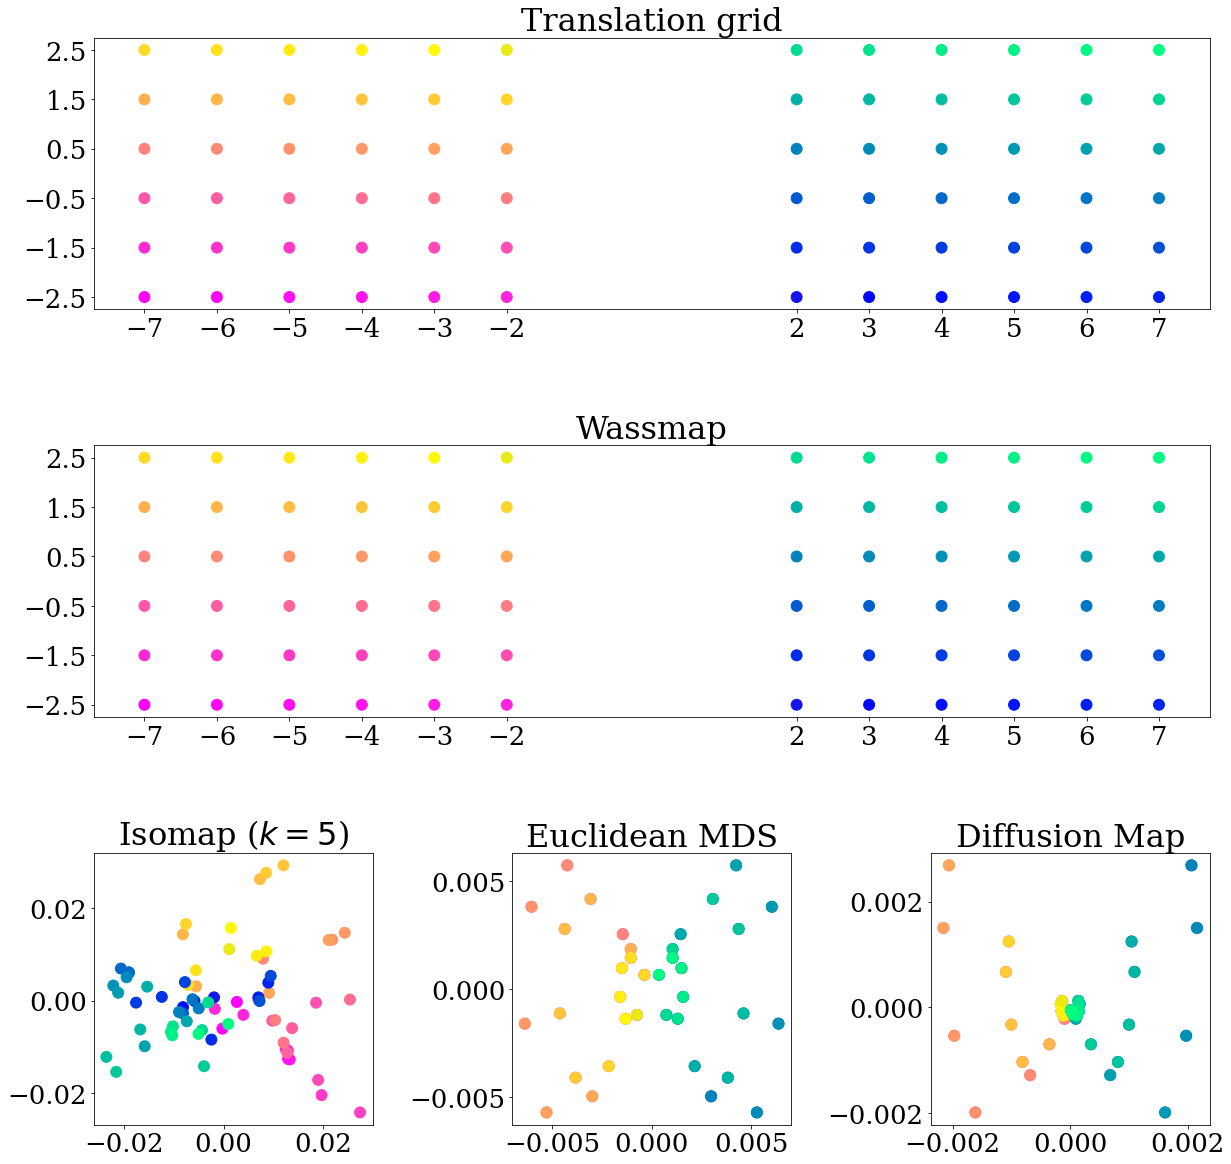

In [69]:
### FIGURE 2: Circle translate test 2:DOUBLE GRID:Plotting

# Create the plot objects 
#fig2,ax2 = plt.subplots(5,1,figsize=(15,20))

fig2 = plt.figure(figsize=(20,20))
ax2 = fig2.subplot_mosaic(
    """
    AAA
    BBB
    CDE
    """,
    gridspec_kw = {"wspace":0.5,"hspace":0.5}
)

# Build a custom split colormap 
import matplotlib.colors as mcolors
colors1 = plt.cm.spring(np.linspace(0, 1, num_samp_f2_each))
colors2 = plt.cm.winter(np.linspace(0, 1, num_samp_f2_each))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('mymap',colors)

ms = 120 # Marker size 
c = np.linspace(0,1,num_samp_f2_total)   # Note: we'll use the same colors for every scatter plot (to identify points)

# Plot the translation set 
xtick = np.concatenate((x1,x2))
xp = translates_f2[:,0]
yp = translates_f2[:,1]
ax2['A'].scatter(xp,yp,c=c,s=ms,cmap=mymap)
ax2['A'].set_title('Translation grid')
ax2['A'].set_xticks(xtick)
ax2['A'].set_yticks(y_f2)

# Plot Wassmap embedding
xp = WassEmbedding_f2[:,0]
yp = WassEmbedding_f2[:,1]
ax2['B'].scatter(xp,yp,c=c,s=ms,cmap=mymap)
ax2['B'].set_title('Wassmap')
ax2['B'].set_xticks(xtick)
ax2['B'].set_yticks(y_f2)

# Plot the Isomap embedding
xp = IsomapEmbedding_f2[:,0]
yp = IsomapEmbedding_f2[:,1]
ax2['C'].scatter(xp,yp,c=c,s=ms,cmap=mymap)
ax2['C'].set_title("Isomap ($k = %i$)"%isomap_k)

# Plot the Euclidean MDS embedding
xp = MDSEmbedding_f2[:,0]
yp = MDSEmbedding_f2[:,1]
ax2['D'].scatter(xp,yp,c=c,s=ms,cmap=mymap)
ax2['D'].set_title("Euclidean MDS")

# Plot the diffusion map embedding 
xp = DMapEmbedding_f2[:,0]
yp = DMapEmbedding_f2[:,1]
ax2['E'].scatter(xp,yp,c=c,s=ms,cmap=mymap)
ax2['E'].set_title('Diffusion Map')

# Save the figure to google drive 
fig2.savefig('./figures/fig2.pdf',bbox_inches='tight')

In [33]:
### FIGURE 3: Circle dilation test 1::Computations
##  

# Generate circle
num_samplepoints = 64
radius = 1
circ = wm.generate_circle([0,0],radius,samples=num_samplepoints)

# Generate dilation set
num_dilates = 5
num_samp_f3 = num_dilates**2
x_f3 = np.linspace(.5,2,num=num_dilates)
y_f3 = np.linspace(.5,4,num=num_dilates)
xx,yy = np.meshgrid(x_f3,y_f3) #num_dilates x num_dilates matrices; each xx,yy entry is a dilation vector
xx = np.reshape(xx,(num_samp_f3,1))
yy = np.reshape(yy,(num_samp_f3,1))
dilates = np.zeros((num_samp_f3,2))
for i in range(len(xx)):
    dilates[i,0] = xx[i]
    dilates[i,1] = yy[i]

# Generate dilation images and image tensor
dil_images = []
for i in range(num_samp_f3):
    img = np.concatenate((wm.dilation(circ,[dilates[i,0],dilates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    dil_images.append(img)

# Generate voxel images (for ISOmap)
nvox = 256
nxg = nvox
nyg = nvox

xg = np.linspace(-2,2,nxg)
yg = np.linspace(-4,4,nyg)
xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
grid = np.stack((xxg,yyg))
dil_images_vox = np.zeros((nvox,nvox,num_dilates**2))
vox_matrix_f3 = np.zeros((num_samp_f3,nvox*nvox))
for i in range(num_samp_f3):
    pc = dil_images[i]
    dil_images_vox[:,:,i] = wm.pointcloud_to_vox(pc,grid)
    vox_matrix_f3[i,:] = np.reshape(dil_images_vox[:,:,i],(1,nvox*nvox))

In [ ]:
# Compute Wasserstein square distance matrix
tic = time.perf_counter()
Wass_distance_dil = wm.wass_matrix(dil_images,squared=True,geodesic=False)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp_f3,toc))

# MDS on Wass squared matrix to obtain the Wassmap embedding
WassEmbedding_dil = wm.mds(Wass_distance_dil,squared=True)

In [23]:
# Compute Euclidean distance matrix and Euclidean MDS embedding
euc_matrix_f3 = wm.euc_matrix(dil_images_vox,geodesic=False,squared=True,plot=False)
MDSEmbedding_f3 = wm.mds(euc_matrix_f3,squared=True)

# Compute isomap using sklearn 
isomap_k = 5
IsomapEmbedding_f3 = man.Isomap(n_components=2,n_neighbors=isomap_k).fit_transform(vox_matrix_f3)

# Compute the diffusion map 
neighbor_params = {'n_jobs': -1, 'algorithm': 'kd_tree'} 
dmap_f3 = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 1.0, neighbor_params = neighbor_params)
DMapEmbedding_f3 = dmap_f3.fit_transform(vox_matrix_f3)

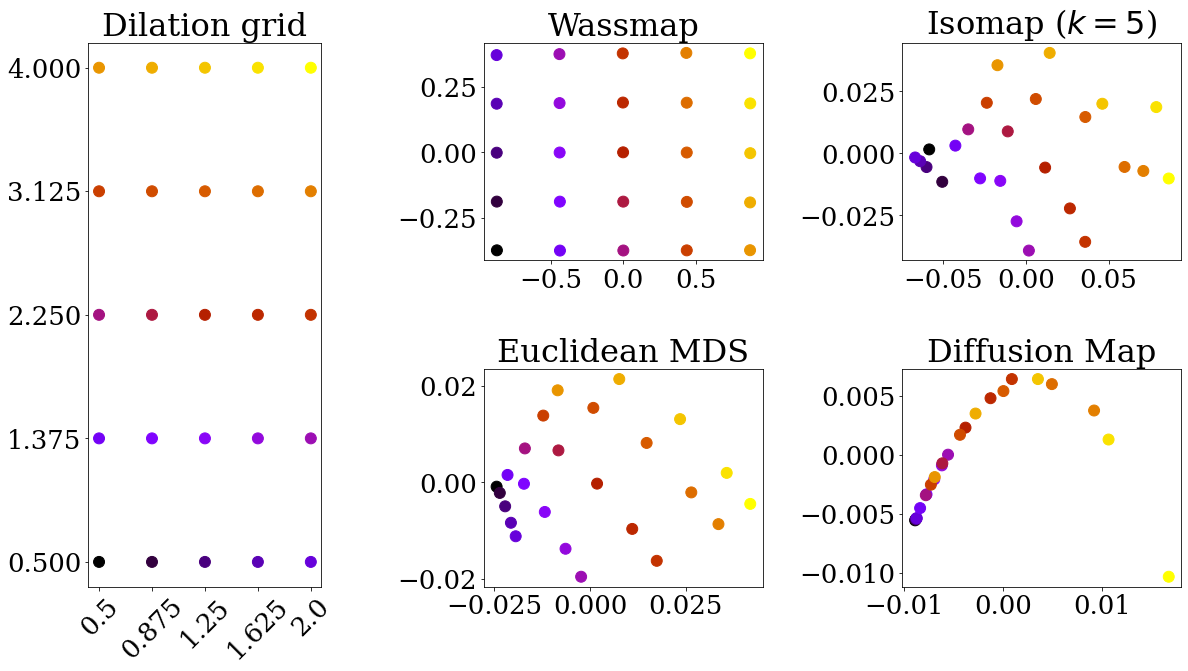

In [83]:
### FIGURE 3: Circle dilation test 1:Plotting

# Create the plot objects 
fig3 = plt.figure(figsize=(20,10))
ax3 = fig3.subplot_mosaic(
    """
    ABC
    ADE
    """,
    gridspec_kw = {"wspace":0.5,"hspace":0.5}
)

ms = 120 # Marker size 
c = np.linspace(0,1,num_samp_f3) # Note: we'll use the same colors for every scatter plot (to identify points)

# Plot the dilation set 
xp = dilates[:,0]
yp = dilates[:,1]
ax3['A'].scatter(xp,yp,c=c,s=ms)
ax3['A'].set_title('Dilation grid')
ax3['A'].set_aspect(1)
ax3['A'].set_xticks(x_f3)
ax3['A'].set_yticks(y_f3)
ax3['A'].set_xticklabels(ax3['A'].get_xticks(), rotation = 45)

# Plot Wassmap embedding
scatter_x = WassEmbedding_dil[:,0]
scatter_y = WassEmbedding_dil[:,1]
ax3['B'].scatter(scatter_x,scatter_y,c=c,s=ms)
#ax3['B'].set_aspect('equal')
ax3['B'].set_title('Wassmap')

xp = IsomapEmbedding_f3[:,0]
yp = IsomapEmbedding_f3[:,1]
# Plot the ISOMAP embedding
ax3['C'].scatter(xp,yp,c=c,s=ms)
#ax3['C'].set_aspect(1)
ax3['C'].set_title("Isomap ($k = %i$)"%isomap_k)

# Plot the MDS embedding 
xp = MDSEmbedding_f3[:,0]
yp = MDSEmbedding_f3[:,1]
ax3['D'].scatter(xp,yp,c=c,s=ms)
#ax3['D'].set_aspect(1)
ax3['D'].set_title("Euclidean MDS")

# Plot the diffusion map embedding 
xp = DMapEmbedding_f3[:,0]
yp = DMapEmbedding_f3[:,1]
ax3['E'].scatter(xp,yp,c=c,s=ms)
#ax3['E'].set_aspect(1)
ax3['E'].set_title('Diffusion Map')

# Save the figure to google drive 
fig3.savefig('./figures/fig3.pdf',bbox_inches='tight')

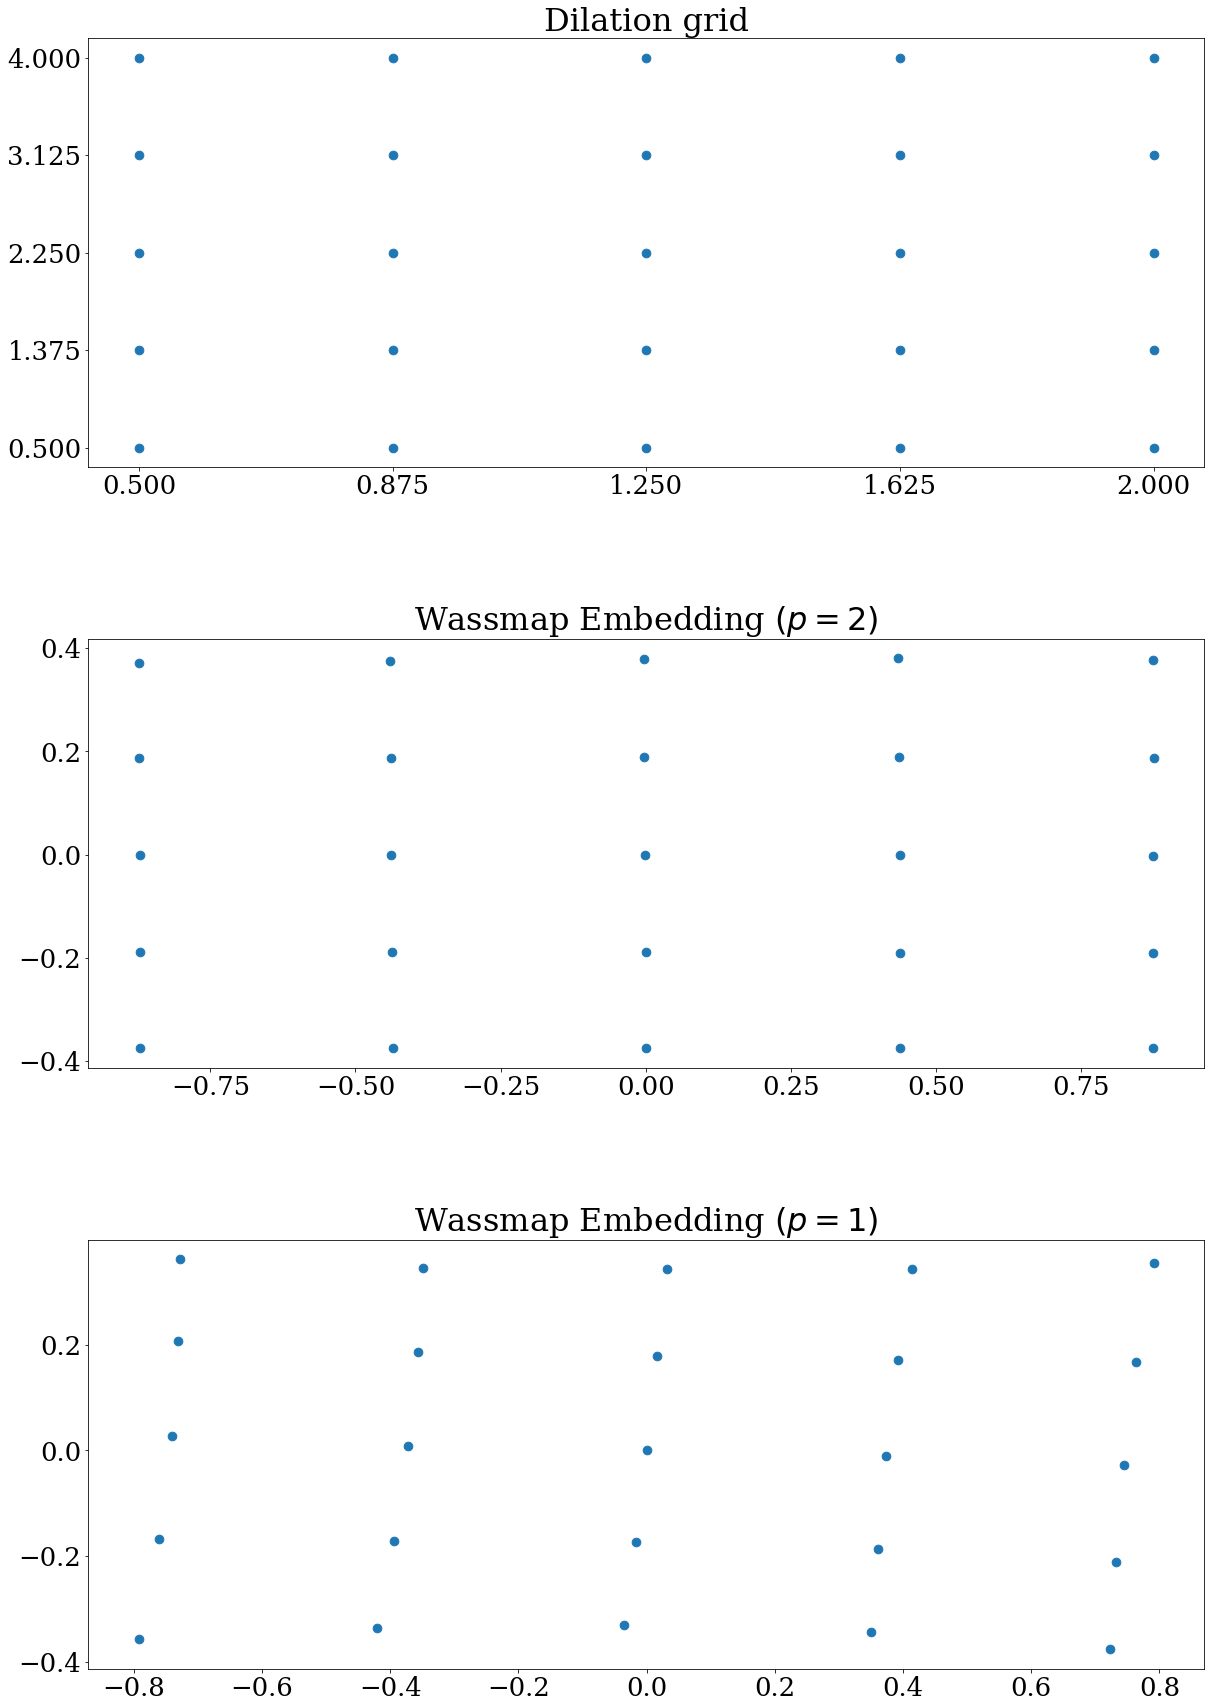

In [ ]:
### Supplemental dilation figure:Comparing Wass with p=1 to p=2:Plotting

# Create the plot objects 
fig3_supp = plt.figure(figsize=(20,30))
ax3 = fig3_supp.subplot_mosaic(
    """
    A
    B
    C
    """,
    gridspec_kw = {"wspace":0.6,"hspace":0.4}
)

# Plot the dilation set 
scatter_x = dilates[:,0]
scatter_y = dilates[:,1]
ax3['A'].scatter(scatter_x,scatter_y,s=75)
ax3['A'].set_title('Dilation grid')
ax3['A'].set_xticks(x)
ax3['A'].set_yticks(y)

# Plot Wassmap embedding
scatter_x = WassEmbedding_dil[:,0]
scatter_y = WassEmbedding_dil[:,1]
ax3['B'].scatter(scatter_x,scatter_y,s=75)
ax3['B'].set_title('Wassmap Embedding $(p=2)$')

# Plot the Wassmap embedding
scatter_x = WassEmbedding_p1[:,0]
scatter_y = WassEmbedding_p1[:,1]
ax3['C'].scatter(scatter_x,scatter_y,s=75)
ax3['C'].set_title('Wassmap Embedding $(p=1)$')

# Save the figure to google drive 
fig3_supp.savefig('/content/drive/My Drive/Colab Notebooks/figures/revisions/fig3_supp.pdf',bbox_inches='tight')

In [84]:
### FIGURE 4: Ellipse rotation test::Computations

# Generate ellipse
num_samplepoints = 64
ellipse = wm.generate_ellipse([0,1], 1, .5, samples = num_samplepoints)

# Generate translation set
num_rotations = 21
theta = np.linspace(0,2*np.pi,num=num_rotations,endpoint=False)
x_f4 = np.cos(theta)
y_f4 = np.sin(theta)
rotates = np.zeros((num_rotations,2))
for i in range(len(x_f4)):
    rotates[i,0] = x_f4[i]
    rotates[i,1] = y_f4[i]
    
rot_images = []
for i in range(rotates.shape[0]):
    img = np.concatenate((wm.rotation(ellipse,theta[i]),np.ones((ellipse.shape[0],1))/ellipse.shape[0]),axis=1)
    rot_images.append(img)

# Generate voxel images (for ISOmap)
nvox = 256
xg = np.linspace(-6,6,nvox)
xxg,yyg = np.meshgrid(xg,xg,indexing='ij')
grid = np.stack((xxg,yyg))
rot_images_vox = np.zeros((nvox,nvox,len(rot_images)))
vox_matrix_f4 = np.zeros((num_rotations,nvox*nvox))
for i in range(len(rot_images)):
    pc = rot_images[i]
    rot_images_vox[:,:,i] = wm.pointcloud_to_vox(pc,grid)
    vox_matrix_f4[i,:] = np.reshape(rot_images_vox[:,:,i],(1,nvox*nvox))

# Compute Wasserstein square distance matrix
tic = time.perf_counter()
Wass_distance_rot = wm.wass_matrix(rot_images,squared=True,geodesic=False)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_rotations,toc))
# MDS on Wass squared matrix to obtain the Wassmap embedding
WassEmbedding_rot = wm.mds(Wass_distance_rot,squared=True)

/Users/nick/opt/anaconda3/lib/python3.9/site-packages/ot/lp/__init__.py:554: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Computed Wasserstein distance matrix (N = 21) in 233.7570 seconds


In [85]:
# Compute Euclidean distance matrix and MDS embedding
euc_matrix = wm.euc_matrix(rot_images_vox,geodesic=False,squared=True,plot=False)
MDSEmbedding_f4 = wm.mds(euc_matrix,squared=True)

# Compute the ISOMAP embedding 
isomap_k = 5
IsomapEmbedding_f4 = man.Isomap(n_components=2,n_neighbors=isomap_k).fit_transform(vox_matrix_f4)

# Compute the diffusion map 
neighbor_params = {'n_jobs': -1, 'algorithm': 'kd_tree'} 
dmap_f4 = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 1.0, neighbor_params = neighbor_params)
DMapEmbedding_f4 = dmap_f4.fit_transform(vox_matrix_f4)

/var/folders/yq/ycx24n5j4ysbzlhns70dbm400000gn/T/ipykernel_40746/3985163930.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4['C'].set_xticklabels(ax4['C'].get_xticks(), rotation = 45)
/var/folders/yq/ycx24n5j4ysbzlhns70dbm400000gn/T/ipykernel_40746/3985163930.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4['D'].set_xticklabels(ax4['D'].get_xticks(), rotation = 45)
/var/folders/yq/ycx24n5j4ysbzlhns70dbm400000gn/T/ipykernel_40746/3985163930.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4['E'].set_xticklabels(ax4['E'].get_xticks(), rotation = 45)


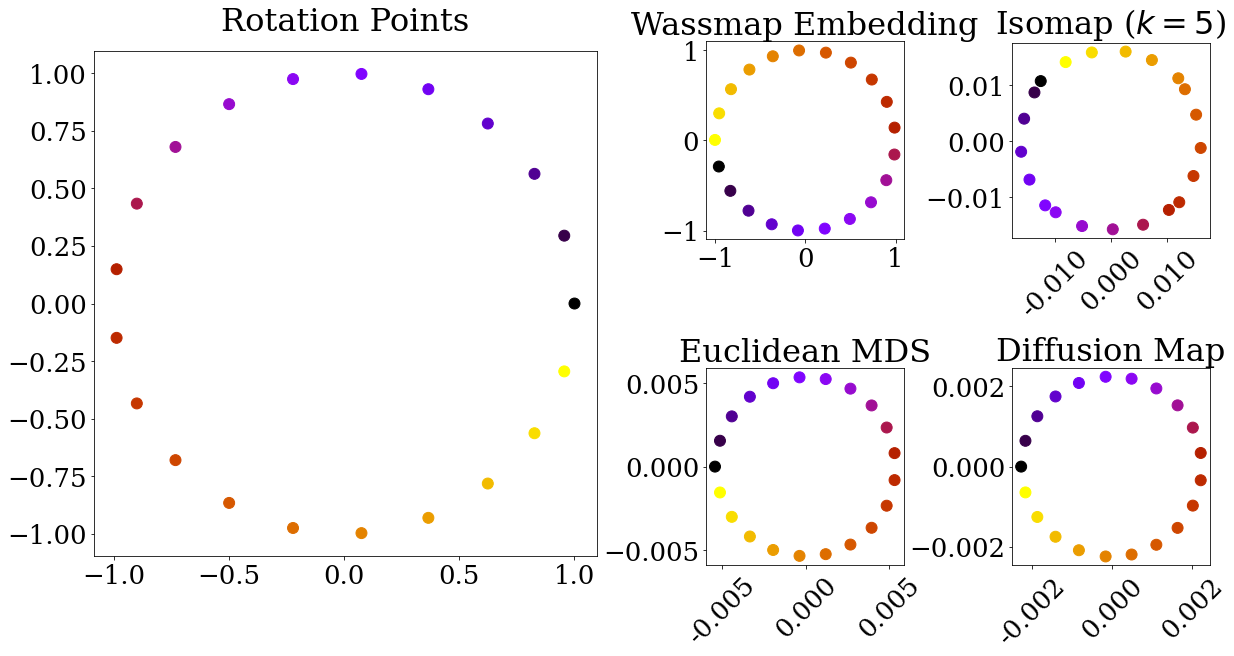

In [93]:
### FIGURE 4: Ellipse rotation test:Plotting

# Create the figure 
fig4 = plt.figure(figsize=(20,10))
ax4 = fig4.subplot_mosaic(
    """
    AABC
    AADE
    """,
    gridspec_kw = {"wspace":0.55,"hspace":0.5}
)

ms = 120 # Marker size 
c = np.linspace(0,10,num_rotations) # Note: we'll use the same colors for every scatter plot (to identify points)

# Plot the rotation set 
xp = rotates[:,0]
yp = rotates[:,1]

ax4['A'].scatter(xp,yp,c=c,s=ms)
ax4['A'].set_aspect('equal')
ax4['A'].set_title('Rotation Points',pad=20)

# Plot Wassmap embedding
xp = WassEmbedding_rot[:,0]
yp = WassEmbedding_rot[:,1]
ax4['B'].scatter(xp,yp,c=c,s=ms)
ax4['B'].set_aspect('equal')
ax4['B'].set_title('Wassmap Embedding')

# Plot the ISOMAP embedding
xp = IsomapEmbedding_f4[:,0]
yp = IsomapEmbedding_f4[:,1]
ax4['C'].scatter(xp,yp,c=c,s=ms)
ax4['C'].set_aspect('equal')
ax4['C'].set_title("Isomap ($k = %i$)"%isomap_k)
ax4['C'].set_xticklabels(ax4['C'].get_xticks(), rotation = 45)
ax4['C'].get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.3f'))

# Plot the MDS embedding
xp = MDSEmbedding_f4[:,0]
yp = MDSEmbedding_f4[:,1]
ax4['D'].scatter(xp,yp,c=c,s=ms)
ax4['D'].set_aspect('equal')
ax4['D'].set_title("Euclidean MDS")
ax4['D'].set_xticklabels(ax4['D'].get_xticks(), rotation = 45)
ax4['D'].get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.3f'))

# Plot the diffusion map embedding 
xp = DMapEmbedding_f4[:,0]
yp = DMapEmbedding_f4[:,1]
ax4['E'].scatter(xp,yp,c=c,s=ms)
ax4['E'].set_aspect('equal')
ax4['E'].set_title('Diffusion Map')
ax4['E'].set_xticklabels(ax4['E'].get_xticks(), rotation = 45)
ax4['E'].get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.3f'))

# Save the figure to google drive 
fig4.savefig('./figures/fig4.pdf',bbox_inches='tight')

In [ ]:
# For mnist digits
from keras.datasets import mnist
(train_X,train_y), (test_X,test_y) = mnist.load_data()

# Break out individual digit classes
zeros = train_X[train_y==0]
ones = train_X[train_y==1]
twos = train_X[train_y==2]
threes = train_X[train_y==3]
fours = train_X[train_y==4]
fives = train_X[train_y==5]
sixes = train_X[train_y==6]
sevens = train_X[train_y==7]
eights = train_X[train_y==8]
nines = train_X[train_y==9]

# Create pointclouds 
nxg = 28
x = np.linspace(0,1,nxg)
xx,yy = np.meshgrid(x,x,indexing='ij')
grid = np.stack((xx,yy))

## NOTE: Need to have dynamic sizing for pointcloud tensor because output size of vox_to_pointcloud is not consistent
# Zeros
zeros_pointcloud = list()
for i in range(zeros.shape[0]):
    zeros_pointcloud.append(vox_to_pointcloud(zeros[i,:,:],grid))
# Ones
ones_pointcloud = list()
for i in range(ones.shape[0]):
    ones_pointcloud.append(vox_to_pointcloud(ones[i,:,:],grid))
# Twos
twos_pointcloud = list()
for i in range(twos.shape[0]):
    twos_pointcloud.append(vox_to_pointcloud(twos[i,:,:],grid))
# Threes
threes_pointcloud = list()
for i in range(threes.shape[0]):
    threes_pointcloud.append(vox_to_pointcloud(threes[i,:,:],grid))
# Fours
fours_pointcloud = list()
for i in range(fours.shape[0]):
    fours_pointcloud.append(vox_to_pointcloud(fours[i,:,:],grid))
# Fives
fives_pointcloud = list()
for i in range(fives.shape[0]):
    fives_pointcloud.append(vox_to_pointcloud(fives[i,:,:],grid))
# Sixes
sixes_pointcloud = list()
for i in range(sixes.shape[0]):
    sixes_pointcloud.append(vox_to_pointcloud(sixes[i,:,:],grid))
# Sevens
sevens_pointcloud = list()
for i in range(sevens.shape[0]):
    sevens_pointcloud.append(vox_to_pointcloud(sevens[i,:,:],grid))
# Eights
eights_pointcloud = list()
for i in range(eights.shape[0]):
    eights_pointcloud.append(vox_to_pointcloud(eights[i,:,:],grid))
# Nines
nines_pointcloud = list()
for i in range(nines.shape[0]):
    nines_pointcloud.append(vox_to_pointcloud(nines[i,:,:],grid))


fig,ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].imshow(zeros[0,:,:],origin='lower')
ax[1].scatter(zeros_pointcloud[0][:,0],zeros_pointcloud[0][:,1],s=50,c=zeros_pointcloud[0][:,2])
ax[1].set_aspect(1)

In [ ]:
image_tensor = np.concatenate((zeros,ones))
print(zeros.shape)
print(image_tensor.shape)

(5923, 28, 28)
(12665, 28, 28)


minimum nonzero distance = 0.0212
minimum nonzero distance = 0.0212
Computed Wasserstein distance matrix (N = 25) in 171.4858 seconds


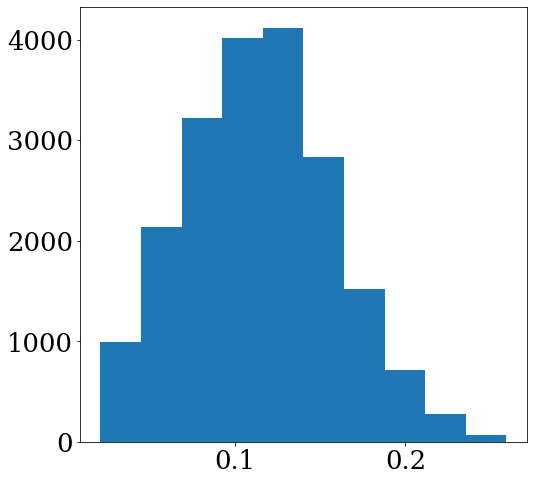

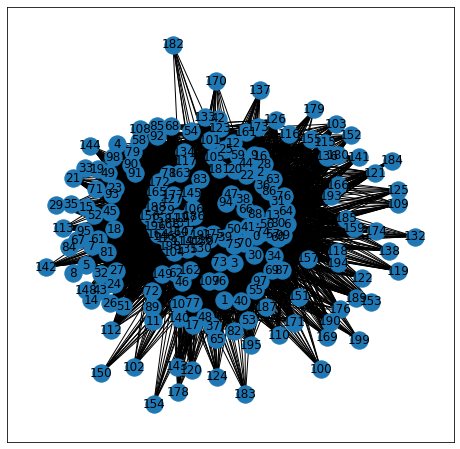

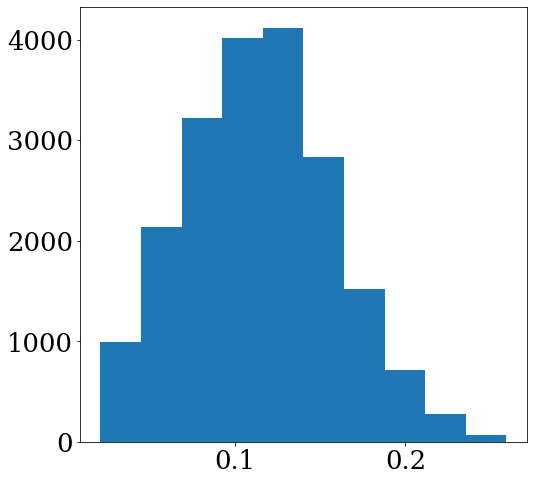

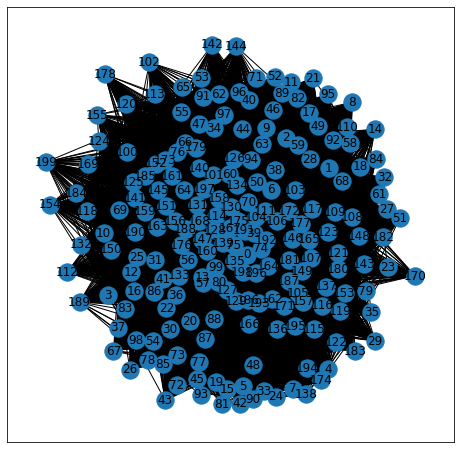

In [ ]:
### FIGURE 6: MNIST DIGITS 

# Select random digits 
numdigits = 100
random_zeros  = np.random.choice(range(len(zeros_pointcloud)),size=numdigits,replace=False)
random_ones   = np.random.choice(range(len(ones_pointcloud)),size=numdigits,replace=False)
random_twos   = np.random.choice(range(len(twos_pointcloud)),size=numdigits,replace=False)
random_threes = np.random.choice(range(len(threes_pointcloud)),size=numdigits,replace=False)
random_fours  = np.random.choice(range(len(fours_pointcloud)),size=numdigits,replace=False)
random_fives  = np.random.choice(range(len(fives_pointcloud)),size=numdigits,replace=False)
random_sixes  = np.random.choice(range(len(sixes_pointcloud)),size=numdigits,replace=False)
random_sevens = np.random.choice(range(len(sevens_pointcloud)),size=numdigits,replace=False)
random_eights = np.random.choice(range(len(eights_pointcloud)),size=numdigits,replace=False)
random_nines  = np.random.choice(range(len(nines_pointcloud)),size=numdigits,replace=False)

digits = list()

for i in random_ones:
    digits.append(ones_pointcloud[i])
for i in random_sevens:
    digits.append(sevens_pointcloud[i])
#for i in random_twos:
#    digits.append(twos_pointcloud[i])

total_num = len(digits)
# Compute Wasserstein square distance matrix
tic = time.perf_counter()
Wass_distance = Wasserstein_Matrix(digits,squared=True,geodesic=False)
wass_eps_1 = 0.14
wass_eps_2 = 0.1
Wass_distance_geo_1 = Wasserstein_Matrix(digits,squared=True,geodesic=True,eps=wass_eps_1,plot=True)
Wass_distance_geo_2 = Wasserstein_Matrix(digits,squared=True,geodesic=True,eps=wass_eps_2,plot=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))

# MDS on Wass squared matrix to obtain the Wassmap embedding
WassEmbedding       = MDS(Wass_distance,squared=True)
WassEmbedding_geo_1 = MDS(Wass_distance_geo_1,squared=True)
WassEmbedding_geo_2 = MDS(Wass_distance_geo_2,squared=True)



In [ ]:
# Build the image tensor & reshape for sklearn
image_tensor = np.concatenate((ones,twos,sevens))
nvox = 28
vox_matrix = np.zeros((total_num,nvox*nvox))
for i in range(total_num):
    vox_matrix[i,:] = np.reshape(image_tensor[i,:,:],(1,nvox*nvox))
# Compute isomap using sklearn 
isomap_k_1 = 3
EucEmbedding_skl_1 = man.Isomap(n_components=2,n_neighbors=isomap_k_1).fit_transform(vox_matrix)
isomap_k_2 = 6
EucEmbedding_skl_2 = man.Isomap(n_components=2,n_neighbors=isomap_k_2).fit_transform(vox_matrix)
isomap_k_3 = 20
EucEmbedding_skl_3 = man.Isomap(n_components=2,n_neighbors=isomap_k_3).fit_transform(vox_matrix)

# Compute the spectral embedding (AKA Laplacian Eigenmap)
numneighbors = 6
SpecEmbedding = man.SpectralEmbedding(n_components=2,affinity='nearest_neighbors',n_neighbors=numneighbors).fit_transform(vox_matrix)

# Compute the diffusion map 
neighbor_params = {'n_jobs': -1, 'algorithm': 'kd_tree'} 
mydmap = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 1.0, neighbor_params = neighbor_params)
DMapEmbedding = mydmap.fit_transform(vox_matrix)

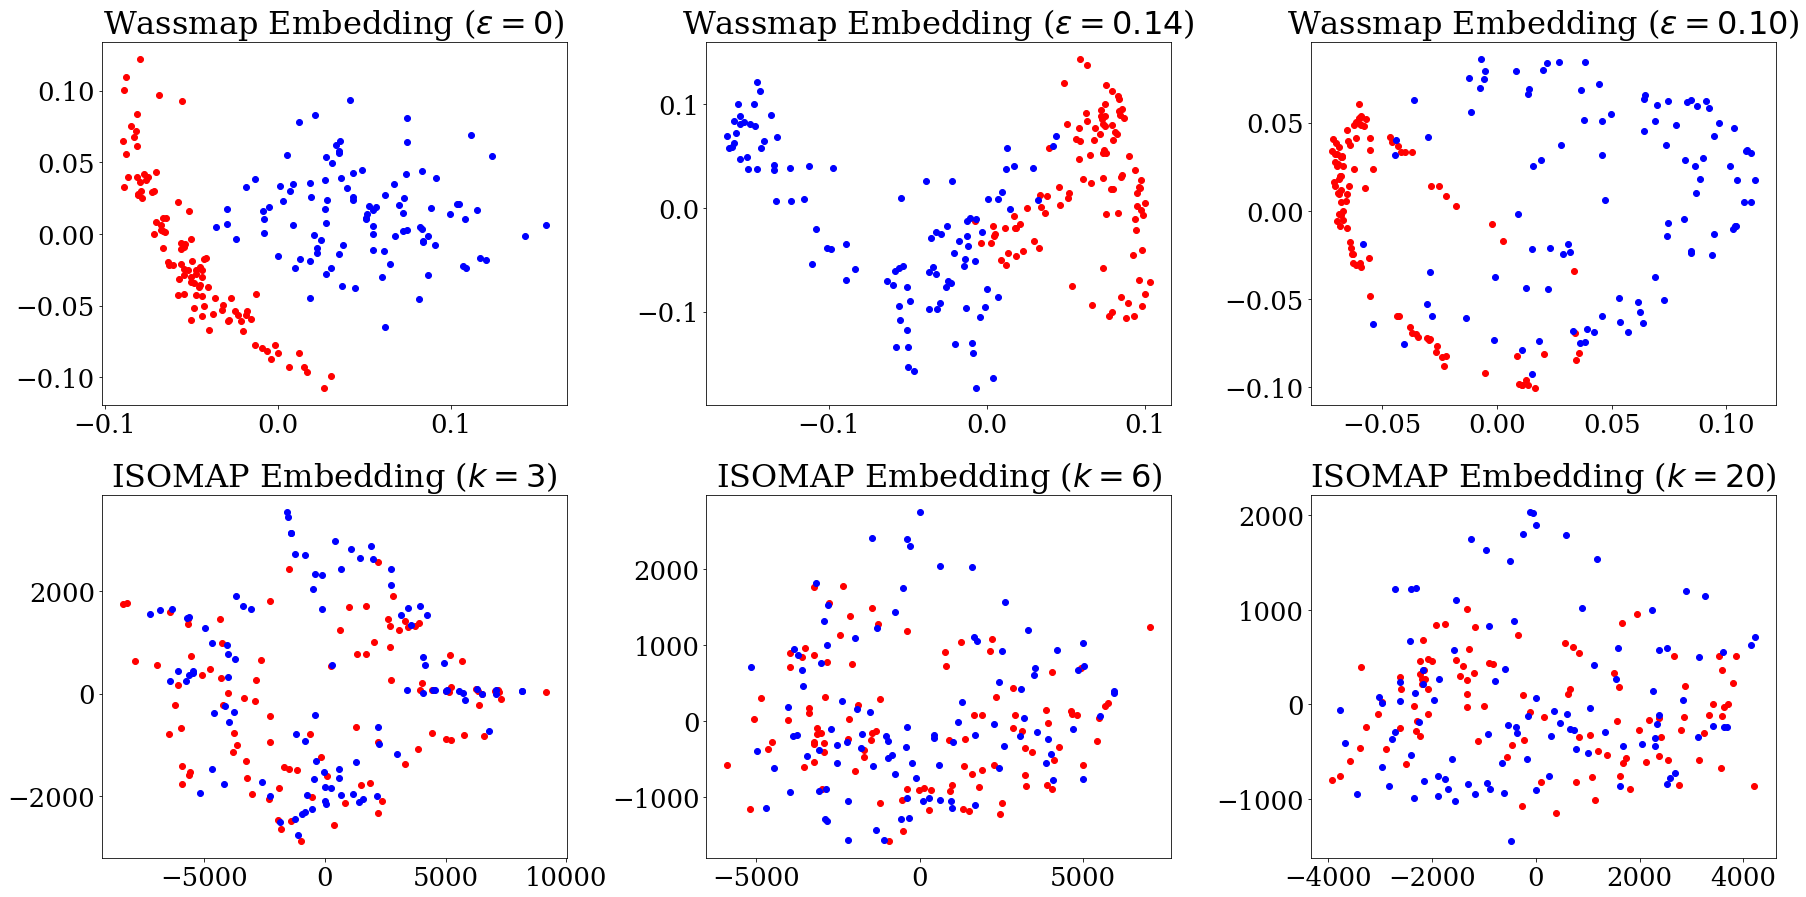

In [ ]:
# Plotting
fig, ax = plt.subplots(2,3,figsize=(30,15),
    gridspec_kw = {"wspace":0.3,"hspace":0.25})
num_zeros = len(random_zeros)
num_ones = len(random_ones)
num_twos = len(random_twos)
num_sevens = len(random_sevens)
#num_twos = len(random_twos)

L = num_ones
M = num_sevens
N = num_twos

ax[0,0].scatter(WassEmbedding[range(L),0],WassEmbedding[range(L),1],c='r')
ax[0,0].scatter(WassEmbedding[range(L,L+M),0],WassEmbedding[range(L,L+M),1],c='b')
#ax[0,0].scatter(WassEmbedding[range(L+M,L+M+N),0],WassEmbedding[range(L+M,L+M+N),1],c='g')
ax[0,0].set_title("Wassmap Embedding ($\epsilon=0$)")

ax[0,1].scatter(WassEmbedding_geo_1[range(L),0],WassEmbedding_geo_1[range(L),1],c='r')
ax[0,1].scatter(WassEmbedding_geo_1[range(L,L+M),0],WassEmbedding_geo_1[range(L,L+M),1],c='b')
#ax[0,0].scatter(WassEmbedding[range(L+M,L+M+N),0],WassEmbedding[range(L+M,L+M+N),1],c='g')
ax[0,1].set_title("Wassmap Embedding ($\epsilon=%1.2f$)"%wass_eps_1)

ax[0,2].scatter(WassEmbedding_geo_2[range(L),0],WassEmbedding_geo_2[range(L),1],c='r')
ax[0,2].scatter(WassEmbedding_geo_2[range(L,L+M),0],WassEmbedding_geo_2[range(L,L+M),1],c='b')
#ax[0,0].scatter(WassEmbedding[range(L+M,L+M+N),0],WassEmbedding[range(L+M,L+M+N),1],c='g')
ax[0,2].set_title("Wassmap Embedding ($\epsilon=%1.2f$)"%wass_eps_2)

ax[1,0].scatter(EucEmbedding_skl_1[range(L),0],EucEmbedding_skl_1[range(L),1],c='r')
ax[1,0].scatter(EucEmbedding_skl_1[range(L,L+M),0],EucEmbedding_skl_1[range(L,L+M),1],c='b')
#ax[0,1].scatter(EucEmbedding_skl[range(L+M,L+M+N),0],EucEmbedding_skl[range(L+M,L+M+N),1],c='g')
ax[1,0].set_title("ISOMAP Embedding ($k = %i$)"%isomap_k_1)

ax[1,1].scatter(EucEmbedding_skl_2[range(L),0],EucEmbedding_skl_2[range(L),1],c='r')
ax[1,1].scatter(EucEmbedding_skl_2[range(L,L+M),0],EucEmbedding_skl_2[range(L,L+M),1],c='b')
#ax[0,1].scatter(EucEmbedding_skl[range(L+M,L+M+N),0],EucEmbedding_skl[range(L+M,L+M+N),1],c='g')
ax[1,1].set_title("ISOMAP Embedding ($k = %i$)"%isomap_k_2)

ax[1,2].scatter(EucEmbedding_skl_3[range(L),0],EucEmbedding_skl_3[range(L),1],c='r')
ax[1,2].scatter(EucEmbedding_skl_3[range(L,L+M),0],EucEmbedding_skl_3[range(L,L+M),1],c='b')
#ax[0,1].scatter(EucEmbedding_skl[range(L+M,L+M+N),0],EucEmbedding_skl[range(L+M,L+M+N),1],c='g')
ax[1,2].set_title("ISOMAP Embedding ($k = %i$)"%isomap_k_3)

#ax[1,1].scatter(SpecEmbedding[range(L),0],SpecEmbedding[range(L),1],c='r')
#ax[1,1].scatter(SpecEmbedding[range(L,L+M),0],SpecEmbedding[range(L,L+M),1],c='b')
#ax[1,0].scatter(SpecEmbedding[range(L+M,L+M+N),0],SpecEmbedding[range(L+M,L+M+N),1],c='g')
#ax[1,1].set_title("Laplacian Eigenmap Embedding ($k = %i$)"%numneighbors)

#ax[1,2].scatter(DMapEmbedding[range(L),0],DMapEmbedding[range(L),1],c='r')
#ax[1,2].scatter(DMapEmbedding[range(L,L+M),0],DMapEmbedding[range(L,L+M),1],c='b')
#ax[1,1].scatter(DMapEmbedding[range(L+M,L+M+N),0],DMapEmbedding[range(L+M,L+M+N),1],c='g')
#ax[1,2].set_title("Diffusion Map Embedding ")

plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/revisions/fig6.pdf',bbox_inches='tight')